<a href="https://colab.research.google.com/github/stwind/gan-experiments/blob/master/notebooks/wgan_gp_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/stwind/gan-experiments.git

  Cloning https://github.com/stwind/gan-experiments.git to /tmp/pip-req-build-i549vpwh
  Running command git clone -q https://github.com/stwind/gan-experiments.git /tmp/pip-req-build-i549vpwh
  Created wheel for ganexp: filename=ganexp-0.1.0-cp36-none-any.whl size=2179 sha256=4651be4a92fb06a37caa35337e2586934a4c22dba785bbabe88571f2a9af8e82
  Stored in directory: /tmp/pip-ephem-wheel-cache-kngmfmnx/wheels/18/5a/22/e68350bcac451328de5c989e0eb5501bb0ea96fc2e1035287c
Successfully built ganexp


## Setup

In [37]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision.utils import make_grid
from torchvision.transforms import Compose, Normalize, ToTensor, Resize
from torchsummary import summary
from fastprogress.fastprogress import progress_bar
from sklearn.datasets import make_swiss_roll
from matplotlib.gridspec import GridSpec

import ganexp.utils as utils

sns.set('notebook', 'darkgrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 6),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 13,
})
plt.style.use("dark_background")

print("info:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

info:
numpy: 1.19.4
seaborn: 0.11.0
matplotlib: 3.2.2
pytorch: 1.7.0+cu101
cuda device #0: Tesla T4
current device type: cuda


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data

In [6]:
image_size = 32
batch_size = 64

transform = Compose([
    Resize(image_size),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])
])
denormalize = Normalize((-1.0,), (1.0/0.5,))

train_dataset = dset.MNIST(root='data/mnist', train=True, download=True, transform=transform)
test_dataset = dset.MNIST(root='data/mnist', train=False, download=True, transform=transform)

dataloader = DataLoader(ConcatDataset([train_dataset, test_dataset]), batch_size=batch_size, shuffle=True)

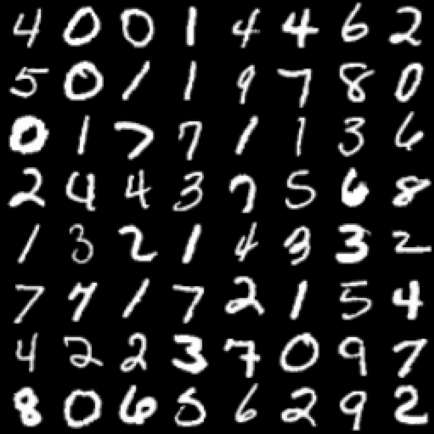

In [7]:
images, _ = next(iter(dataloader))

fig, ax = plt.subplots(figsize=(4,4))

img = make_grid(denormalize(images[:64]), nrow=8, padding=0).permute(1,2,0).numpy()

ax.imshow(img)
ax.set_axis_off()

with plt.rc_context({"savefig.pad_inches": 0}):
    plt.show()

## Model

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)

class Generator(nn.Module):
    def __init__(self, latent_dim, d=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, d * 8, 4, 1, 0),
            nn.BatchNorm2d(d * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(d * 8, d * 4, 4, 2, 1),
            nn.BatchNorm2d(d * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(d * 4, d * 2, 4, 2, 1),
            nn.BatchNorm2d(d * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(d * 2, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, d=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, d, 4, 2, 1),
            nn.InstanceNorm2d(d),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(d, d * 2, 4, 2, 1),
            nn.InstanceNorm2d(d * 2),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(d * 2, d * 4, 4, 2, 1),
            nn.InstanceNorm2d(d * 4),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(d * 4, 1, 4, 1, 0),
        )

    def forward(self, x):
        outputs = self.net(x)
        return outputs.squeeze()
    
nz = 100
ngf = 16
ndf = 16
nc = 1

print("Generator")
netG = Generator(nz).to(device)
netG.apply(weights_init)
summary(netG, (nz,1,1))

print("Discriminator")
netD = Discriminator().to(device)
netD.apply(weights_init)
summary(netD, (nc,image_size,image_size))

Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,856
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,416
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,136
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10            [-1, 1, 32, 32]           1,025
             Tanh-11            [-1, 1, 32, 32]               0
Total params: 1,067,329
Trainable params: 1,067,329
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB):

## Training

In [9]:
def compute_gradient_penalty(netD, real, fake, center=1., lp=True):
    alpha = torch.rand(real.size(0), 1,1,1, device=device).expand_as(real)
    interpolates = alpha * real + (1. - alpha) * fake
    outputs = netD(interpolates)
    gradients = torch.autograd.grad(outputs=outputs, inputs=interpolates,
                                    grad_outputs=torch.ones_like(outputs, device=real.device),
                                    create_graph=True, retain_graph=True)[0]

    gradients = gradients.flatten(start_dim=1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
    gradients_norm = gradients_norm - center
    if lp:
        gradients_norm = gradients_norm.maximum(gradients_norm.new_tensor(0.))
    return gradients_norm.square().mean()

In [11]:
epoch_start, epoch_end = 0, 20

save_path = "/content/gdrive/MyDrive/wgan-mnist/"
save_every = 10
stats_every = 200
snap_every = 2

n_critics = 5
gp_lambda = 10

fix_z = torch.randn(batch_size, nz, 1, 1, device=device)

optimizerD = torch.optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizerG = torch.optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))

In [12]:
G_losses = []
D_losses = []
grad_penalties = []
crit_reals = []
crit_fakes = []
fix_results = []

steps = 0
for epoch in progress_bar(range(epoch_start, epoch_end)):
    for i, (data, _) in enumerate(progress_bar(dataloader, leave=False)):
        steps += 1
        data = data.to(device)

        z = torch.randn(data.size(0), nz, 1, 1, device=device)
        generated_data = netG(z)
        grad_penalty = compute_gradient_penalty(netD, data, generated_data) * gp_lambda
        crit_fake = netD(generated_data).mean()
        crit_real = netD(data).mean()
        d_loss = crit_fake - crit_real + grad_penalty

        optimizerD.zero_grad()
        d_loss.backward()
        optimizerD.step()

        if steps % n_critics == 0:
            z = torch.randn(data.size(0), nz, 1, 1, device=device)
            generated_data = netG(z)
            crit_fake = netD(generated_data).mean()
            g_loss = -crit_fake

            optimizerG.zero_grad()
            g_loss.backward()
            optimizerG.step()

            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())
            grad_penalties.append(grad_penalty.item())
            crit_reals.append(crit_real.item())
            crit_fakes.append(crit_fake.item())
        
        if steps % stats_every == 0:
            print('[{:>2}/{:>2}][{:>3}/{:>3}] D_loss: {:.3f} G_loss: {:.3f} CR: {:.3f} CF: {:.3f} GP: {:.3f}'.format(
                epoch, epoch_end, i, len(dataloader),
                d_loss, g_loss, crit_real, crit_fake,
                grad_penalty))

    if epoch % snap_every == 0:
        with torch.no_grad():
            fake = netG(fix_z).cpu()
            fix_results.append(fake)
            
    if (epoch + 1) % save_every == 0:
        torch.save(netG.state_dict(), save_path + 'gen_{:03d}.pt'.format(epoch))
        torch.save(netD.state_dict(), save_path + 'disc_{:03d}.pt'.format(epoch))

[ 0/20][199/1094] D_loss: -5.549 G_loss: 1.609 CR: 5.087 CF: -1.609 GP: 1.093
[ 0/20][399/1094] D_loss: -10.189 G_loss: 5.294 CR: 6.472 CF: -5.294 GP: 1.559
[ 0/20][599/1094] D_loss: -11.212 G_loss: 8.654 CR: 6.895 CF: -8.654 GP: 3.218
[ 0/20][799/1094] D_loss: -8.562 G_loss: 7.133 CR: 4.557 CF: -7.133 GP: 1.881
[ 0/20][999/1094] D_loss: -7.196 G_loss: 5.856 CR: 0.218 CF: -5.856 GP: 0.837


[ 1/20][105/1094] D_loss: -6.794 G_loss: 7.532 CR: 1.567 CF: -7.532 GP: 1.383
[ 1/20][305/1094] D_loss: -5.814 G_loss: 7.442 CR: -1.327 CF: -7.442 GP: 0.562
[ 1/20][505/1094] D_loss: -6.143 G_loss: 6.525 CR: -0.641 CF: -6.525 GP: 0.661
[ 1/20][705/1094] D_loss: -6.200 G_loss: 8.768 CR: -0.731 CF: -8.768 GP: 1.190
[ 1/20][905/1094] D_loss: -5.553 G_loss: 7.680 CR: -2.143 CF: -7.680 GP: 0.963


[ 2/20][ 11/1094] D_loss: -4.665 G_loss: 8.839 CR: -0.394 CF: -8.839 GP: 1.692
[ 2/20][211/1094] D_loss: -4.839 G_loss: 8.349 CR: -3.103 CF: -8.349 GP: 0.419
[ 2/20][411/1094] D_loss: -4.937 G_loss: 8.490 CR: -2.635 CF: -8.490 GP: 0.826
[ 2/20][611/1094] D_loss: -4.551 G_loss: 8.259 CR: -3.898 CF: -8.259 GP: 0.284
[ 2/20][811/1094] D_loss: -4.453 G_loss: 8.806 CR: -2.484 CF: -8.806 GP: 0.551
[ 2/20][1011/1094] D_loss: -4.996 G_loss: 8.558 CR: -3.245 CF: -8.558 GP: 0.645


[ 3/20][117/1094] D_loss: -4.509 G_loss: 7.849 CR: -3.668 CF: -7.849 GP: 0.446
[ 3/20][317/1094] D_loss: -4.226 G_loss: 8.036 CR: -2.273 CF: -8.036 GP: 0.839
[ 3/20][517/1094] D_loss: -4.140 G_loss: 7.312 CR: -3.239 CF: -7.312 GP: 0.149
[ 3/20][717/1094] D_loss: -3.706 G_loss: 7.474 CR: -2.940 CF: -7.474 GP: 0.687
[ 3/20][917/1094] D_loss: -4.554 G_loss: 7.514 CR: -2.038 CF: -7.514 GP: 0.588


[ 4/20][ 23/1094] D_loss: -4.519 G_loss: 6.630 CR: -1.777 CF: -6.630 GP: 0.571
[ 4/20][223/1094] D_loss: -3.958 G_loss: 7.393 CR: -2.356 CF: -7.393 GP: 0.616
[ 4/20][423/1094] D_loss: -4.155 G_loss: 6.849 CR: -2.199 CF: -6.849 GP: 0.520
[ 4/20][623/1094] D_loss: -3.929 G_loss: 7.027 CR: -2.478 CF: -7.027 GP: 0.439
[ 4/20][823/1094] D_loss: -3.926 G_loss: 6.325 CR: -1.686 CF: -6.325 GP: 0.601
[ 4/20][1023/1094] D_loss: -3.782 G_loss: 5.729 CR: -1.549 CF: -5.729 GP: 0.320


[ 5/20][129/1094] D_loss: -3.877 G_loss: 5.307 CR: -1.492 CF: -5.307 GP: 0.681
[ 5/20][329/1094] D_loss: -3.409 G_loss: 5.414 CR: -2.321 CF: -5.414 GP: 0.359
[ 5/20][529/1094] D_loss: -3.994 G_loss: 5.901 CR: -1.479 CF: -5.901 GP: 0.409
[ 5/20][729/1094] D_loss: -3.631 G_loss: 5.877 CR: -1.227 CF: -5.877 GP: 0.736
[ 5/20][929/1094] D_loss: -4.092 G_loss: 4.920 CR: -1.299 CF: -4.920 GP: 0.188


[ 6/20][ 35/1094] D_loss: -4.189 G_loss: 4.817 CR: -0.414 CF: -4.817 GP: 0.506
[ 6/20][235/1094] D_loss: -3.996 G_loss: 5.023 CR: -0.866 CF: -5.023 GP: 0.412
[ 6/20][435/1094] D_loss: -3.671 G_loss: 4.821 CR: -1.193 CF: -4.821 GP: 0.290
[ 6/20][635/1094] D_loss: -3.556 G_loss: 6.184 CR: -1.814 CF: -6.184 GP: 0.233
[ 6/20][835/1094] D_loss: -3.425 G_loss: 5.114 CR: -0.880 CF: -5.114 GP: 0.387
[ 6/20][1035/1094] D_loss: -3.675 G_loss: 5.461 CR: -1.150 CF: -5.461 GP: 0.443


[ 7/20][141/1094] D_loss: -3.260 G_loss: 5.995 CR: -2.556 CF: -5.995 GP: 0.265
[ 7/20][341/1094] D_loss: -3.718 G_loss: 6.177 CR: -2.054 CF: -6.177 GP: 0.330
[ 7/20][541/1094] D_loss: -3.267 G_loss: 4.087 CR: -0.251 CF: -4.087 GP: 0.378
[ 7/20][741/1094] D_loss: -3.647 G_loss: 4.865 CR: -0.066 CF: -4.865 GP: 0.572
[ 7/20][941/1094] D_loss: -3.740 G_loss: 5.909 CR: -1.901 CF: -5.909 GP: 0.290


[ 8/20][ 47/1094] D_loss: -3.548 G_loss: 4.415 CR: -0.645 CF: -4.415 GP: 0.565
[ 8/20][247/1094] D_loss: -3.478 G_loss: 4.401 CR: -0.933 CF: -4.401 GP: 0.332
[ 8/20][447/1094] D_loss: -3.034 G_loss: 5.686 CR: -0.761 CF: -5.686 GP: 0.772
[ 8/20][647/1094] D_loss: -3.192 G_loss: 5.029 CR: 0.060 CF: -5.029 GP: 0.998
[ 8/20][847/1094] D_loss: -2.775 G_loss: 3.368 CR: -0.667 CF: -3.368 GP: 0.217
[ 8/20][1047/1094] D_loss: -3.725 G_loss: 4.520 CR: 0.056 CF: -4.520 GP: 0.593


[ 9/20][153/1094] D_loss: -3.818 G_loss: 4.932 CR: -1.248 CF: -4.932 GP: 0.370
[ 9/20][353/1094] D_loss: -3.504 G_loss: 4.018 CR: -0.618 CF: -4.018 GP: 0.380
[ 9/20][553/1094] D_loss: -2.640 G_loss: 5.035 CR: -1.880 CF: -5.035 GP: 0.262
[ 9/20][753/1094] D_loss: -3.070 G_loss: 3.751 CR: 0.138 CF: -3.751 GP: 0.673
[ 9/20][953/1094] D_loss: -2.887 G_loss: 5.110 CR: -0.686 CF: -5.110 GP: 0.589


[10/20][ 59/1094] D_loss: -3.046 G_loss: 4.822 CR: -0.382 CF: -4.822 GP: 0.515
[10/20][259/1094] D_loss: -3.516 G_loss: 3.712 CR: 0.126 CF: -3.712 GP: 0.375
[10/20][459/1094] D_loss: -3.542 G_loss: 4.456 CR: -0.999 CF: -4.456 GP: 0.231
[10/20][659/1094] D_loss: -2.592 G_loss: 3.995 CR: -0.600 CF: -3.995 GP: 0.561
[10/20][859/1094] D_loss: -3.368 G_loss: 3.458 CR: 0.352 CF: -3.458 GP: 0.500
[10/20][1059/1094] D_loss: -3.297 G_loss: 3.633 CR: -0.346 CF: -3.633 GP: 0.393


[11/20][165/1094] D_loss: -2.995 G_loss: 4.407 CR: -0.572 CF: -4.407 GP: 0.502
[11/20][365/1094] D_loss: -3.564 G_loss: 4.450 CR: -0.665 CF: -4.450 GP: 0.316
[11/20][565/1094] D_loss: -2.706 G_loss: 5.104 CR: -1.217 CF: -5.104 GP: 0.292
[11/20][765/1094] D_loss: -3.326 G_loss: 4.019 CR: -0.363 CF: -4.019 GP: 0.383
[11/20][965/1094] D_loss: -3.128 G_loss: 4.465 CR: -1.213 CF: -4.465 GP: 0.634


[12/20][ 71/1094] D_loss: -2.897 G_loss: 4.548 CR: -1.277 CF: -4.548 GP: 0.195
[12/20][271/1094] D_loss: -2.646 G_loss: 3.855 CR: -1.029 CF: -3.855 GP: 0.369
[12/20][471/1094] D_loss: -3.340 G_loss: 4.354 CR: -0.544 CF: -4.354 GP: 0.375
[12/20][671/1094] D_loss: -2.343 G_loss: 4.442 CR: -1.586 CF: -4.442 GP: 0.144
[12/20][871/1094] D_loss: -2.986 G_loss: 3.289 CR: -0.360 CF: -3.289 GP: 0.319
[12/20][1071/1094] D_loss: -3.324 G_loss: 3.893 CR: -0.514 CF: -3.893 GP: 0.291


[13/20][177/1094] D_loss: -2.115 G_loss: 3.877 CR: -1.122 CF: -3.877 GP: 0.414
[13/20][377/1094] D_loss: -3.136 G_loss: 3.514 CR: -0.883 CF: -3.514 GP: 0.259
[13/20][577/1094] D_loss: -3.338 G_loss: 3.822 CR: 0.200 CF: -3.822 GP: 0.621
[13/20][777/1094] D_loss: -2.836 G_loss: 3.769 CR: -0.106 CF: -3.769 GP: 0.401
[13/20][977/1094] D_loss: -3.586 G_loss: 3.040 CR: -0.011 CF: -3.040 GP: 0.275


[14/20][ 83/1094] D_loss: -3.283 G_loss: 3.465 CR: 0.167 CF: -3.465 GP: 0.392
[14/20][283/1094] D_loss: -2.633 G_loss: 3.559 CR: -1.067 CF: -3.559 GP: 0.182
[14/20][483/1094] D_loss: -2.630 G_loss: 3.539 CR: -0.587 CF: -3.539 GP: 0.247
[14/20][683/1094] D_loss: -2.219 G_loss: 4.190 CR: -0.860 CF: -4.190 GP: 0.695
[14/20][883/1094] D_loss: -2.801 G_loss: 3.708 CR: -0.780 CF: -3.708 GP: 0.244
[14/20][1083/1094] D_loss: -2.978 G_loss: 2.625 CR: 0.681 CF: -2.625 GP: 0.507


[15/20][189/1094] D_loss: -3.059 G_loss: 3.182 CR: -0.321 CF: -3.182 GP: 0.267
[15/20][389/1094] D_loss: -3.085 G_loss: 2.998 CR: 1.352 CF: -2.998 GP: 0.660
[15/20][589/1094] D_loss: -2.888 G_loss: 3.919 CR: -0.662 CF: -3.919 GP: 0.123
[15/20][789/1094] D_loss: -2.548 G_loss: 3.136 CR: 0.781 CF: -3.136 GP: 0.620
[15/20][989/1094] D_loss: -2.502 G_loss: 3.672 CR: -0.222 CF: -3.672 GP: 0.324


[16/20][ 95/1094] D_loss: -2.531 G_loss: 2.268 CR: 0.426 CF: -2.268 GP: 0.289
[16/20][295/1094] D_loss: -3.023 G_loss: 2.582 CR: 0.057 CF: -2.582 GP: 0.214
[16/20][495/1094] D_loss: -2.418 G_loss: 2.073 CR: 0.959 CF: -2.073 GP: 0.329
[16/20][695/1094] D_loss: -2.889 G_loss: 2.798 CR: 0.024 CF: -2.798 GP: 0.208
[16/20][895/1094] D_loss: -3.062 G_loss: 2.441 CR: 0.448 CF: -2.441 GP: 0.134


[17/20][  1/1094] D_loss: -2.530 G_loss: 3.781 CR: -0.449 CF: -3.781 GP: 0.264
[17/20][201/1094] D_loss: -2.622 G_loss: 3.240 CR: -0.168 CF: -3.240 GP: 0.375
[17/20][401/1094] D_loss: -2.617 G_loss: 1.956 CR: 0.572 CF: -1.956 GP: 0.358
[17/20][601/1094] D_loss: -2.661 G_loss: 2.060 CR: 0.313 CF: -2.060 GP: 0.240
[17/20][801/1094] D_loss: -2.024 G_loss: 2.809 CR: 0.305 CF: -2.809 GP: 0.577
[17/20][1001/1094] D_loss: -2.944 G_loss: 2.251 CR: 0.190 CF: -2.251 GP: 0.294


[18/20][107/1094] D_loss: -2.559 G_loss: 2.522 CR: 0.113 CF: -2.522 GP: 0.270
[18/20][307/1094] D_loss: -2.738 G_loss: 2.531 CR: 1.030 CF: -2.531 GP: 0.361
[18/20][507/1094] D_loss: -2.180 G_loss: 3.540 CR: -0.034 CF: -3.540 GP: 0.335
[18/20][707/1094] D_loss: -2.682 G_loss: 3.257 CR: -0.359 CF: -3.257 GP: 0.252
[18/20][907/1094] D_loss: -2.789 G_loss: 3.184 CR: 0.278 CF: -3.184 GP: 0.367


[19/20][ 13/1094] D_loss: -2.989 G_loss: 2.759 CR: 0.001 CF: -2.759 GP: 0.273
[19/20][213/1094] D_loss: -2.843 G_loss: 1.634 CR: 0.944 CF: -1.634 GP: 0.370
[19/20][413/1094] D_loss: -2.053 G_loss: 2.617 CR: -0.051 CF: -2.617 GP: 0.372
[19/20][613/1094] D_loss: -2.943 G_loss: 2.709 CR: 0.674 CF: -2.709 GP: 0.319
[19/20][813/1094] D_loss: -2.017 G_loss: 2.081 CR: 1.205 CF: -2.081 GP: 0.480
[19/20][1013/1094] D_loss: -2.889 G_loss: 1.566 CR: 1.602 CF: -1.566 GP: 0.346


## Results

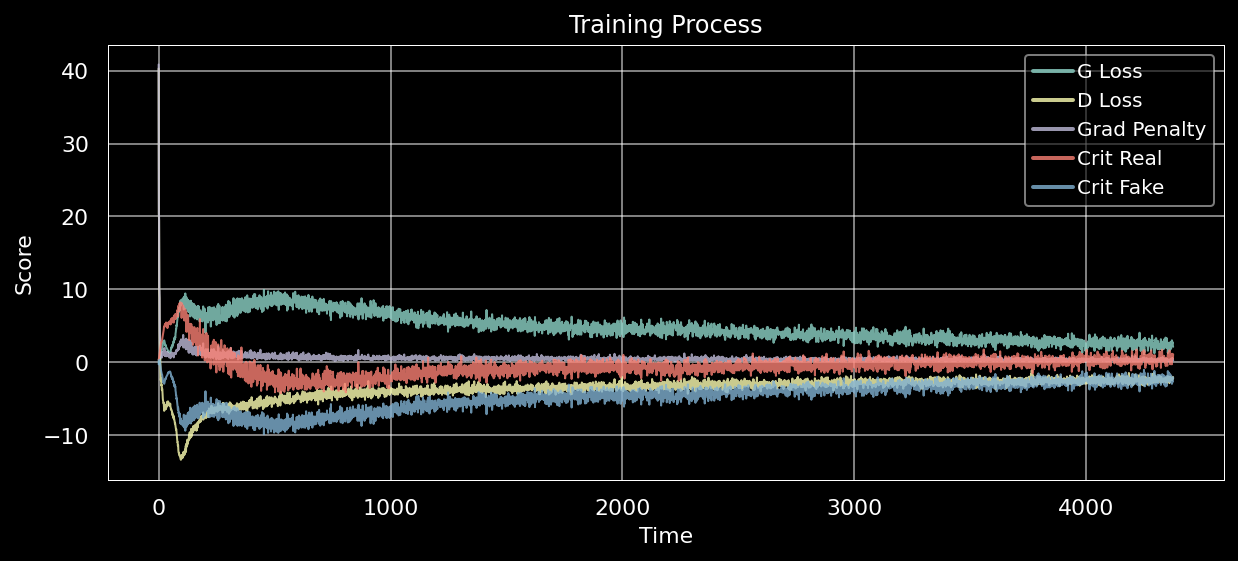

In [38]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(G_losses, label="G Loss", alpha=0.8)
ax.plot(D_losses, label="D Loss", alpha=0.8)
ax.plot(grad_penalties, label="Grad Penalty", alpha=0.8)
ax.plot(crit_reals, label="Crit Real", alpha=0.8)
ax.plot(crit_fakes, label="Crit Fake", alpha=0.8)
ax.set(xlabel="Time", ylabel="Score", title="Training Process")
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(2.0)

plt.show()

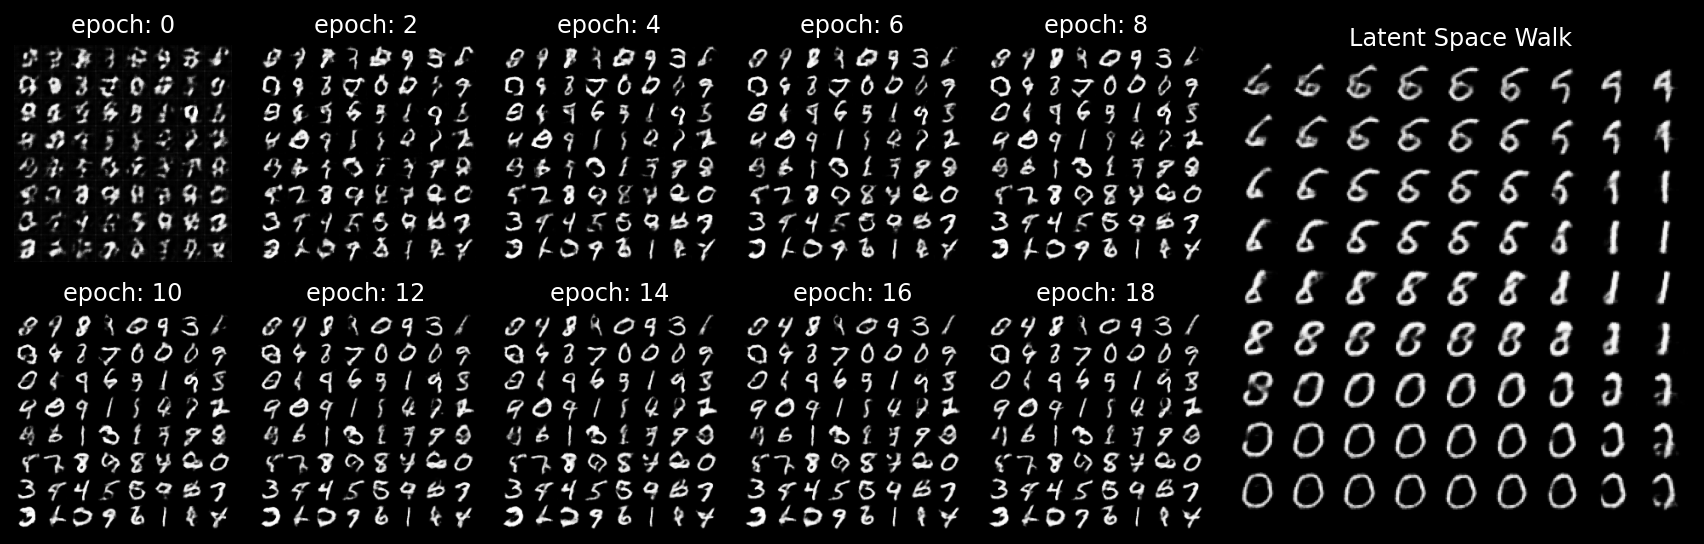

In [50]:
fig = plt.figure(figsize=(12, 4))

gs = GridSpec(2, 7)

for i, img in enumerate(fix_results):
    r, c = divmod(i, 5)
    ax = fig.add_subplot(gs[r, c])
    ax.imshow(make_grid(denormalize(img),nrow=8,padding=0).permute(1,2,0).numpy())
    ax.set_axis_off()
    ax.set_title("epoch: {}".format(i * snap_every),fontsize="medium")

z = utils.make_mine_grid(utils.make_analogy_grid(np.random.randn(5, nz)), nrow=3, space=4)
z = torch.from_numpy(np.expand_dims(z, (2,3))).to(device)
img = netG(z).detach().cpu()

ax = fig.add_subplot(gs[:, 5:])
ax.imshow(make_grid(denormalize(img),nrow=9).permute(1,2,0).numpy())
ax.set_axis_off()
ax.set_title("Latent Space Walk",fontsize="medium")

plt.tight_layout()
plt.show()